<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of 3 Brain Tumors (Meningioma, Glioma and Pituitary) in T1-weighted contrast enhanced images

### - Revisitng the Udacity Capstone Project in pursuit of better accuracy



# What is the problem statement?
  * predict the tumor class given only MRI image
  * OR predict the tumor class when both MRI and Tumor region is given !!!
      * tumor region is identified and put in input dataset by experts
          * can we have Image Segmentation problem ?


  * I think this is the order of problem from easy level to difficult level
    * Identify the tumor class from raw MRI image (here accuracy may be low)
    * Identify the tumor class from raw MRI image + tumor region identified (here accuracy may be better)
    * Auto detect the tumor segment in a MRI image and classify the tumor (ideal application for a radiologist)

    Let us try all the 3 !!!

# Import Packages
* read the input MRI images (.mat) files through ***h5py***
* ***pandas*** for data analysis and preprocessing
* ***tensorflow*** for modelling and predicting

In [0]:
import os
import zipfile
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# Load Data
* Mount Google Drive
* Unzip it in colab disk
* load mat attributes to list of tuples
* create a panda dataframe for analysis

##### Issues Faced:
1. loading to panda with image took half(6GB) of RAM
* loading tumor along with mri image as in mat file crashed the colab
  * Solution: let us load image but save only 5 point summary for both mri image and tumor

2. How do we scale/normalize the data?
  * would tumor region have 0 in it ?
    * only way to know is through the value present in the binary indicator == 1
        * implementation through 2 for loops takes forever !!!
          * need to implement throuhg np.where
        

3. Some images are less than 512
    * pad the difference with 0s.
    
4. Should tumor image be scaled between 0 -1? For now, brightness values are relative to that of the whole image to which it belongs to.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [0]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


In [0]:
def retrieveImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')

    mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
    #scaler = MinMaxScaler(feature_range=(1,2))
    #mri_image = scaler.fit(mri_image)
    mri_image = mri_image/mri_image.max()

    if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
    
    temp_mri_image = np.copy(mri_image)
    temp_mri_image[temp_mri_image == 0 ] = 2

    mri_quartiles = np.percentile(mri_image[mri_image > 0], [25, 50, 75])

    tumor_image = np.array(f['cjdata']['tumorMask'], dtype=np.float128)
    if tumor_image.shape[0] < 512:
      print("Shape of the tumor image : ", tumor_image.shape)
      tumor_image = np.pad(tumor_image,(512 - tumor_image.shape[0])//2,'constant',constant_values=0)
    
    tumor_image = temp_mri_image * tumor_image
    tumor_image = tumor_image[tumor_image > 0]
    tumor_image[tumor_image == 2] = 0

    '''tumor_array =[]
    for i in range(0,512):
      for j in range(0,512):
        if tumor_image[i][j]:
          tumor_array.append(mri_image[i][j])

    tumor_image = np.array(tumor_array, dtype=np.float)'''

    tumor_quartiles = np.percentile(tumor_image, [25, 50, 75])

    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            ,mri_image.min() \
            ,mri_image.max() \
            ,mri_quartiles[1] \
            ,mri_quartiles[0] \
            ,mri_quartiles[2] \
            ,tumor_image.min() \
            ,tumor_image.max() \
            ,tumor_quartiles[1] \
            ,tumor_quartiles[0] \
            ,tumor_quartiles[2] \
            ,tumor_image.shape \
            ,file_name\
            ,np.array(f['cjdata']['label'], dtype=np.int)[0][0] 

In [0]:
def loadDf():
  patients_details = []
  for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
    for f in files:
      if ".zip" in f:
          file = zipfile.ZipFile(root+f, "r")
          for name in file.namelist():
            file.extract(name,".")
            patients_details.append(return_imageInfo_from_mat_file(name))
          #break
      #break
  mri_col_names = ["mri_min","mri_max","mri_median","mri_1q", "mri_3q"]
  tumor_col_names = ["t_min","t_max","t_median","t_1q","t_3q","tumor_size"]
  col_names = ["pid"] + mri_col_names + tumor_col_names+ ["file_name","label"]
  return pd.DataFrame(patients_details,columns=col_names)


In [0]:
tumor_names = ["","meningioma","glioma","pituitary"]
df = loadDf()
df["square_shape"] = df.tumor_size.apply(lambda x: np.sqrt(x[0]))
df.sample(20)

Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (25

,pid,mri_min,mri_max,mri_median,mri_1q,mri_3q,t_min,t_max,t_median,t_1q,t_3q,tumor_size,file_name,label,square_shape
2808,49,0.0,1.0,0.268384,0.041545,0.364769,0.184877,0.997923,0.491899,0.433527,0.547154,"(2235,)",1510.mat,3,47.275787
949,49,0.0,1.0,0.207055,0.053681,0.299080,0.093558,0.578221,0.329755,0.280675,0.374233,"(1833,)",1716.mat,3,42.813549
1113,77,0.0,1.0,0.253026,0.014601,0.297983,0.239577,0.566955,0.357157,0.314121,0.402882,"(1073,)",1880.mat,2,32.756679
2354,49,0.0,1.0,0.241641,0.034954,0.340426,0.025836,0.735562,0.396657,0.281155,0.512158,"(5154,)",1056.mat,3,71.791364
1072,57,0.0,1.0,0.254386,0.054625,0.325758,0.188596,0.652711,0.460526,0.427033,0.490829,"(2289,)",1839.mat,3,47.843495
738,49,0.0,1.0,0.171114,0.016518,0.321898,0.149513,0.625582,0.331639,0.283778,0.402372,"(3682,)",764.mat,2,60.679486
1150,77,0.0,1.0,0.187725,0.009415,0.219342,0.150878,0.370452,0.228990,0.208299,0.249332,"(6827,)",1917.mat,2,82.625662
1465,77,0.0,1.0,0.186025,0.014731,0.218697,0.110104,0.588669,0.218130,0.180548,0.313881,"(7653,)",2232.mat,2,87.481427
1104,77,0.0,1.0,0.193288,0.013281,0.293252,0.148062,0.738335,0.209978,0.199569,0.317570,"(7419,)",1871.mat,2,86.133617
3016,49,0.0,1.0,0.151163,0.022287,0.240310,0.019380,0.505814,0.222868,0.171512,0.323643,"(1472,)",952.mat,3,38.366652


# Analysis


## Statistical Analysis

### MRI Image Analysis

In [0]:
df.pid.unique()

array([49, 57, 53, 77, 56])

There are only 5 patients info present !!!!

In [0]:
df.groupby("pid").agg("count").reset_index()[['pid','mri_min']]

,pid,mri_min
0,49,1427
1,53,2
2,56,13
3,57,401
4,77,1221


In [0]:
df.groupby(["pid","label"]).agg("count").reset_index()[['pid','label','mri_min']]

,pid,label,mri_min
0,49,1,584
1,49,2,126
2,49,3,717
3,53,1,1
4,53,3,1
5,56,1,1
6,56,2,12
7,57,1,122
8,57,2,67
9,57,3,212


In [0]:
df.groupby("label").agg("count").reset_index()[['label','pid']]

,label,pid
0,1,708
1,2,1426
2,3,930


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30a4dba8>]],
      dtype=object)

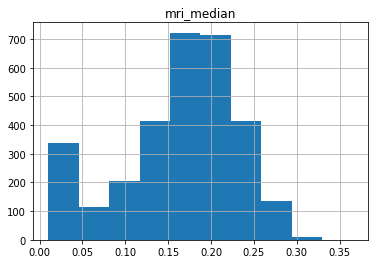

In [0]:
df.hist("mri_median")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30bfbf28>]],
      dtype=object)

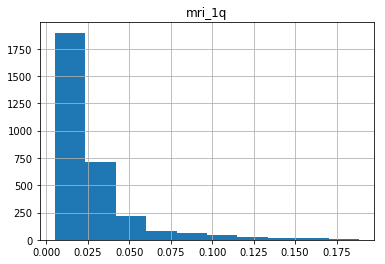

In [0]:
df.hist('mri_1q')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30a097b8>]],
      dtype=object)

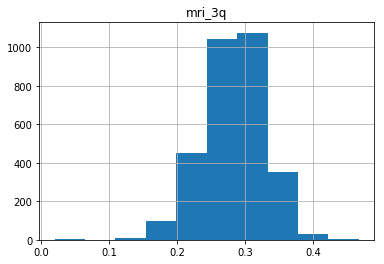

In [0]:
df.hist('mri_3q')

### Tumor Region Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30a129b0>]],
      dtype=object)

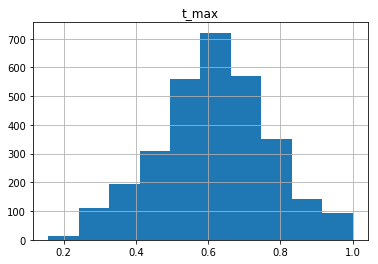

In [0]:
df.hist('t_max')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30acefd0>]],
      dtype=object)

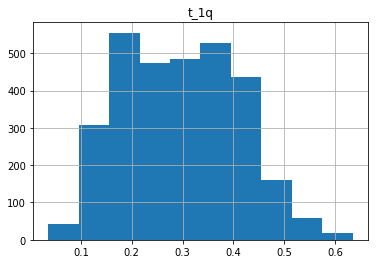

In [0]:
df.hist('t_1q')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a307fe0b8>]],
      dtype=object)

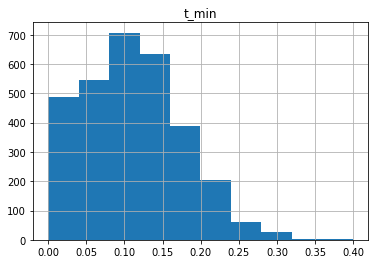

In [0]:

df.hist('t_min')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30b0a160>]],
      dtype=object)

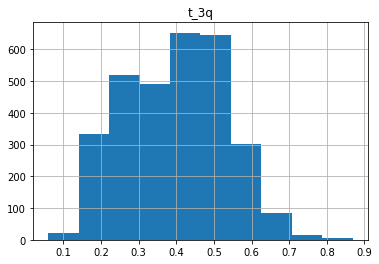

In [0]:
df.hist('t_3q')

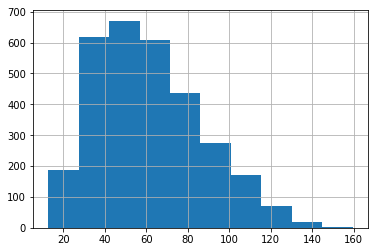

In [0]:
df.square_shape.hist()

## Visual Analysis

### Smallest Tumor Sample

Shape of the image :  (256, 256)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:369: UserWarning: Casting input data from 'float128' to 'float64'for imshow
  "for imshow".format(A.dtype))


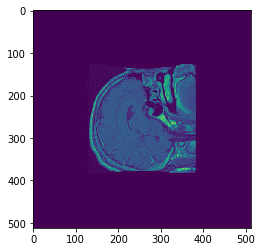

In [0]:
plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]));
plt.show()


### Biggest Tumor in the Dataset

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:369: UserWarning: Casting input data from 'float128' to 'float64'for imshow
  "for imshow".format(A.dtype))


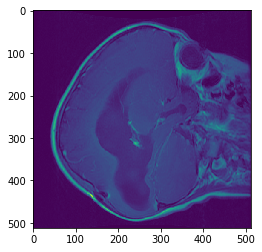

In [0]:
plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]));
plt.show()


### Numpy Resize failed

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:369: UserWarning: Casting input data from 'float128' to 'float64'for imshow
  "for imshow".format(A.dtype))


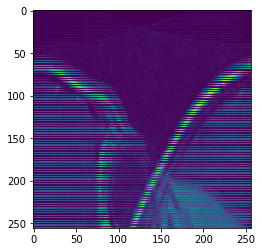

In [0]:
plt.imshow(np.resize(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),(256,256)));
plt.show()

# Preprocessing


Preprocessing ideas:

1.  Dataset has tumor region indicator which would allow us to get the average brightness of the area.

2. It is said that brightest region is skull and skull is not important for the tumor detection. It is only brain position determines the tumor class. If we remove skull remaining image is brain ?

3. if we start with a window of image which would maximize the presence of tumor and expand to include some brain region around the tumor then i guess it is the best data for training(and predicting). Because tumor position in brain is THE factor that decides the tumor class.

4. 



In [0]:
np.int(2.2)

2